# Image Caption Tutorial

In [43]:
from pathlib import Path
import pandas as pd
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Getting the data

```
mkdir coco
wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P ./coco/ 
wget http://images.cocodataset.org/zips/train2014.zip -P ./coco/ 
wget http://images.cocodataset.org/zips/val2014.zip -P ./coco/
```

## Data 

In [4]:
# for this you need to install COCO api follow directions here: http://cocodataset.org/#download
from pycocotools.coco import COCO
import json

In [7]:
PATH = Path("/data2/yinterian/coco")
train_ann = PATH/"annotations/captions_train2014.json"

In [8]:
# loads captions
coco=COCO(train_ann)
coco

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


In [11]:
# all training ids
train_ids = coco.getImgIds()
train_ids[:10]

[57870, 384029, 222016, 520950, 69675, 547471, 122688, 392136, 398494, 90570]

In [32]:
img_id = train_ids[31]
annIds = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(annIds)
print(train_ids[0])
anns

57870


[{'image_id': 356702,
  'id': 190242,
  'caption': "A couple of young men sitting in front of a child's laptop."},
 {'image_id': 356702,
  'id': 203397,
  'caption': 'A pair of men looking at a tablet perched on a table.'},
 {'image_id': 356702,
  'id': 205257,
  'caption': 'Two men laugh as they look at a computer.'},
 {'image_id': 356702,
  'id': 205911,
  'caption': 'Two men are smiling looking at a laptop computer.'},
 {'image_id': 356702,
  'id': 210765,
  'caption': 'Two men happily working on a plastic computer'}]

In [33]:
file = coco.loadImgs(img_id)[0]['file_name']
file

'COCO_train2014_000000356702.jpg'

In [34]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

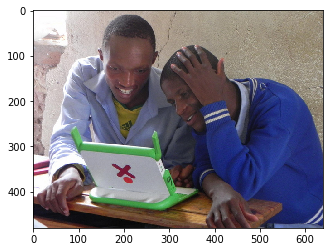

In [35]:
path = PATH/"train2014"/file
im = read_image(path)
plt.imshow(im)

## Data augmentation
Data augmentation is the most important way to avoid overfitting for computer vision tasks.

In [36]:
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

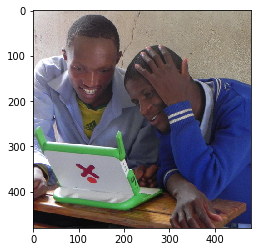

In [40]:
# center crop
im_crop = center_crop(im)
plt.imshow(im_crop)

In [41]:
print(im.shape)

(480, 640, 3)


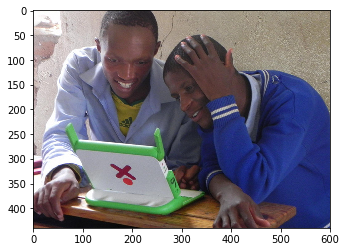

In [47]:
# random crop
im_rand_crop = random_crop(im, 440, 600)
plt.imshow(im_rand_crop)

-5.949093093934814


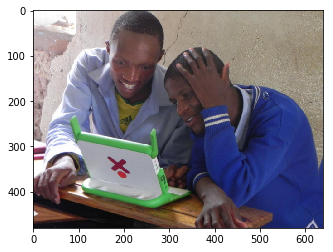

In [49]:
# Random Rotation (-10, 10)
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot)

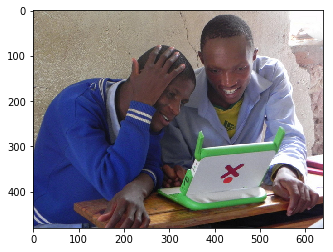

In [50]:
# Horizontal flip
im_f = np.fliplr(im)
plt.imshow(im_f)

## Dataset

In [73]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import cv2

def apply_transforms(x, sz=250, zoom=1.05):
    sz2 = int(zoom*sz)
    x = cv2.resize(x, (sz2, sz2))
    x = random_crop(x, sz, sz)
    rdeg = (np.random.random()-.50)*20
    x = rotate_cv(x, rdeg)
    if np.random.random() > 0.5: x = np.fliplr(x).copy() 
    return x

imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])

def normalize(im, stats=imagenet_stats):
    """Normalizes images with Imagenet stats."""
    return (im - stats[0])/stats[1]

class CocoDataset(Dataset):
    def __init__(self, path, json, vocab, transform=False, sz=250):
        self.path = path
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform
        self.sz = sz
        
    def __getitem__(self, index):
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        filename = coco.loadImgs(img_id)[0]['file_name']
        x = read_image(self.path/filename)
        x = x/255
        x = center_crop(x)
        x = cv2.resize(x, (self.sz, self.sz))
        if self.transform:
            apply_transforms(x)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return torch.FloatTensor(x), caption
        
    def __len__(self):
        return len(len(self.ids))

In [74]:
train = CocoDataset(PATH/"train2014", PATH/"annotations/captions_train2014.json", "")

loading annotations into memory...
Done (t=0.83s)
creating index...
index created!


In [77]:
x, y = train[0]
print(y)
print(x.shape)

A very clean and well decorated empty bathroom
torch.Size([3, 250, 250])


## Computing image features
We use a pre-trained CNN to compute features on each image.

In [ ]:
import torch.nn as nn
from torchvision.models import resnet18

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, pretrained_fn=resnet18, pretrained=True):
        super(ImageNetEncoder, self).__init__()
        resnet = pretrained_fn(pretrained)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        
    def forward(self, x):
        bs = x.shape[0]
        x = self.encoder(x)
        x = torch.cat([self.maxpool(x), self.avgpool(x)], dim=1) # concat pool
        return x.view(bs, -1)

## References
* https://github.com/karpathy/neuraltalk2/blob/master/coco/coco_preprocess.ipynb
* https://github.com/ntrang086/image_captioning
* https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning